# EDA: Digits

In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from helpers.base_imports import *

## Create new EDA

In [4]:
eda = EDA(name="digits")
eda

Loading 'edas.csv'
Creating experiment: 'digits'


EDA: digits
Columns: Index(['description', 'n features', 'n samples', 'f/n ratio', 'noise', 'stats',
       'class balance', 'outliers', 'skewness', 'correlations',
       'DR potential'],
      dtype='object')
Datasets: Index([], dtype='object', name='dataset')

## Get raw dataset from remote source

In [5]:
# fetch dataset
data = load_digits(as_frame=True)
data.frame.head(5)

pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0        0.0        0.0        5.0       13.0        9.0        1.0   
1        0.0        0.0        0.0       12.0       13.0        5.0   
2        0.0        0.0        0.0        4.0       15.0       12.0   
3        0.0        0.0        7.0       15.0       13.0        1.0   
4        0.0        0.0        0.0        1.0       11.0        0.0   

   pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_7  pixel_7_0  \
0        0.0        0.0        0.0        0.0  ...        0.0        0.0   
1        0.0        0.0        0.0        0.0  ...        0.0        0.0   
2        0.0        0.0        0.0        0.0  ...        0.0        0.0   
3        0.0        0.0        0.0        8.0  ...        0.0        0.0   
4        0.0        0.0        0.0        0.0  ...        0.0        0.0   

   pixel_7_1  pixel_7_2  pixel_7_3  pixel_7_4  pixel_7_5  pixel_7_6  \
0        0.0        6.0       13.0       10.0        0.0        0.0   
1        0.0        0.0       11.0       16.0       10.0        0.0   
2        0.0        0.0        3.0       11.0       16.0        9.0   
3        0.0        7.0       13.0       13.0        9.0        0.0   
4        0.0        0.0        2.0       16.0        4.0        0.0   

   pixel_7_7  target  
0        0.0       0  
1        0.0       1  
2        0.0       2  
3        0.0       3  
4        0.0       4  

[5 rows x 65 columns]

In [6]:
list(data.target_names)

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9)]

In [7]:
disp_df(data.frame)

In [8]:
X = data.frame.drop(columns="target")
y = data.frame.target
X.shape, y.shape

((1797, 64), (1797,))

In [9]:
eda.update_param("description", "Classify 10 handwritten digits from 8x8 images")
eda.update_param("n features", X.shape[1])
eda.update_param("n samples", X.shape[0])
eda.update_param("f/n ratio", len(data.target_names) / X.shape[0])

In [10]:
eda.summary_df

description n features n samples  \
dataset                                                                        
digits   Classify 10 handwritten digits from 8x8 images         64      1797   

        f/n ratio noise stats class balance outliers skewness correlations  \
dataset                                                                      
digits   0.005565   NaN   NaN           NaN      NaN      NaN          NaN   

        DR potential  
dataset               
digits           NaN

## Noise

In [11]:
# check for missing values
X.isna().sum().sum()

np.int64(0)

In [12]:
eda.update_param("noise", "None, no missing vals")

## Stats

In [14]:
skewness = X.skew()
summary_stats = X.describe().T
summary_stats["skewness"] = skewness
disp_df(summary_stats[["min", "max", "mean", "std", "skewness", "25%", "50%", "75%"]])

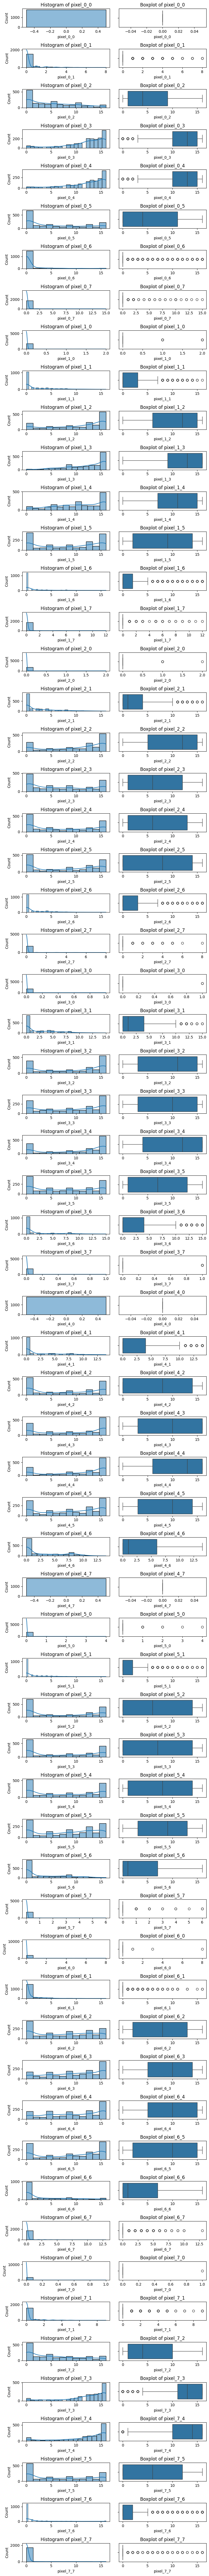

In [15]:
fig, ax = plot_feature_statistics(X, X.columns, line=False)
fig.savefig(f"{FIGS_DIR}/{eda.name}_feature-statistics.png")

In [16]:
eda.update_param("skewness", "many highly skewed features")
eda.update_param("stats", "high variation among features")
eda.update_param("outliers", "many outliers in many features")

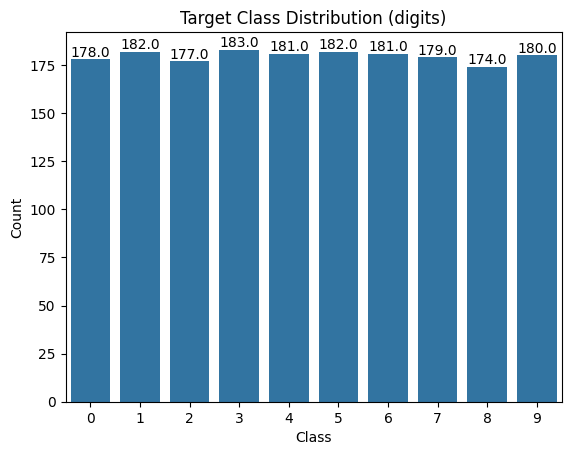

In [18]:
# class distribution of whole dataset
ax = sns.countplot(x=data.target_names[y])
plt.title(f"Target Class Distribution ({eda.name})")
plt.xlabel("Class")
plt.ylabel("Count")

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.savefig(f"{FIGS_DIR}/{eda.name}_target-class-distribution.png")
plt.show()

In [19]:
eda.update_param("class balance", "~Balanced")

## Feature Correlations

In [20]:
# WAY TOO MANY FEATURES TO DO THIS (can do but takes ~2mins and is not very informative)
# df = data.frame.copy()
# df["target"] = data.target_names[y]
# # df.head(5)
# sns.pairplot(data=df, hue="target", palette="bright")
# plt.savefig(f"{FIGS_DIR}/{eda.name}_pairplot.png")

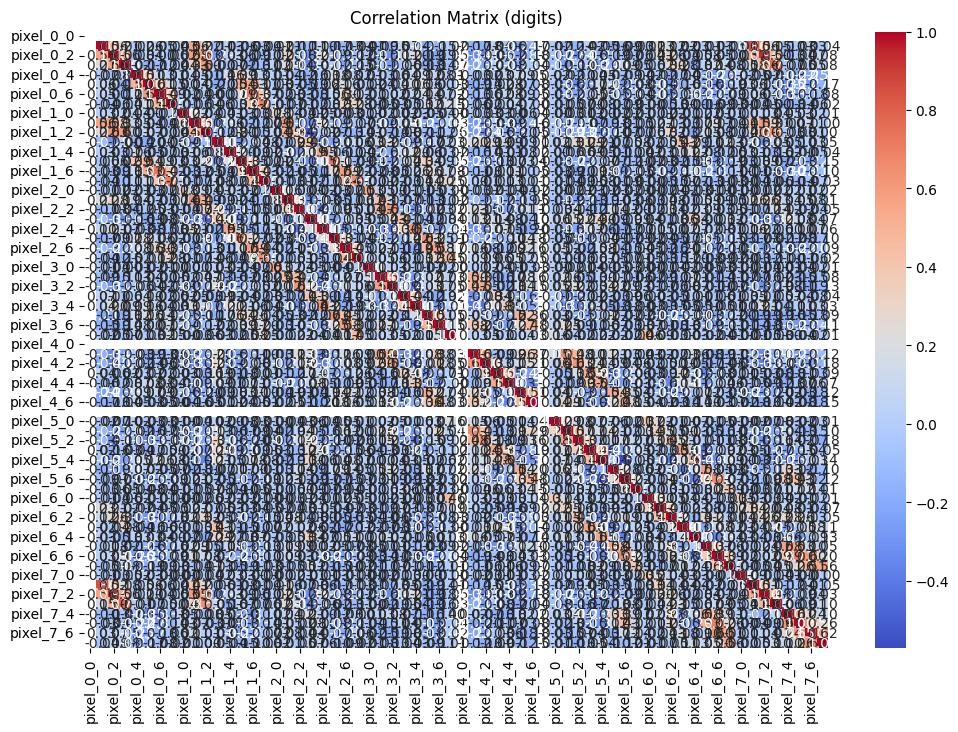

In [21]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Matrix ({eda.name})")

plt.savefig(f"{FIGS_DIR}/{eda.name}_correlation-matrix.png")
plt.show()

In [23]:
eda.update_param(
    "correlations", "strong stripy diagonal cors, some off-diagonal but most weak"
)

## Dimensionality Reduction Potential

In [24]:
# PCA - number of components to explain 95% variance
pca_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA()),
    ]
)
pca_pipe.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

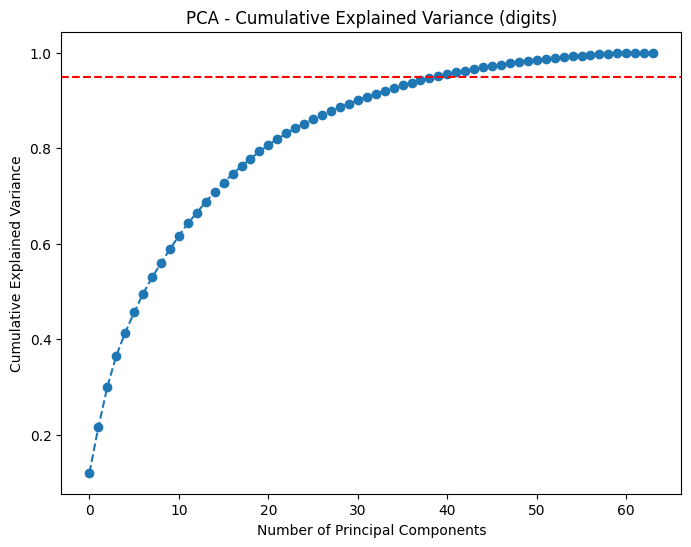

Number of components to explain 95% of the variance: 40


In [25]:
explained_variance_ratio = pca_pipe.named_steps["pca"].explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title(f"PCA - Cumulative Explained Variance ({eda.name})")
plt.axhline(y=0.95, color="r", linestyle="--")  # Threshold for 95% explained variance
plt.show()

# Number of components to explain 95% variance
num_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components to explain 95% of the variance: {num_components_95}")

In [26]:
# ICA - number of independent components
ica_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("ica", FastICA()),
    ]
)
components = ica_pipe.fit_transform(X)

# Number of independent components
num_independent_components = components.shape[1]
print(f"Number of independent components found: {num_independent_components}")

Number of independent components found: 64


/Users/yarik/vc_projects/ML/ml-prep/.venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [28]:
eda.update_param(
    "DR potential",
    "PCA: 95% variance explained with 40 components; ICA: 64 independent components",
)

## Save EDA results

In [29]:
eda.save()

Loading 'edas.csv'
Saving digits to results/edas.csv


---

# Create and save a shuffled 80/20 train/test split